In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

# Load the Dataset

10000
200
[0.0, 0.0, 0.9092974268256817, 0.0, 0.0, -0.9589242746631385, 0.0, 0.0, 0.9893582466233818, 0.0]


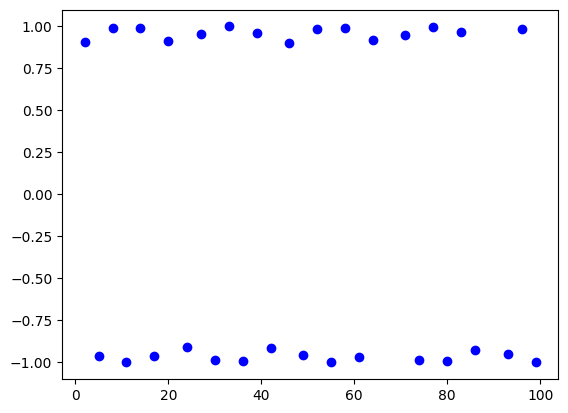

In [77]:
filename = "sin_data.xlsx"

# Load data
data = pd.read_excel(filename)

print(len(data))

# take only the first 100 data points

data = data.iloc[:200]
print(len(data))

# Split the data 50/50

train_data = data.iloc[:int(len(data) / 2)]
test_data = data.iloc[int(len(data) / 2):]

anomalies_train = []

for i in train_data["Sin(X)"]:
    if i > 0.9 or i < -0.9:
        anomalies_train.append(i)
    else:
        anomalies_train.append(0.0)

print(anomalies_train[:10]) 

# plot the anomalies


for i, value in enumerate(anomalies_train):
    if(value != 0):
        plt.scatter(i, value, color="blue", label="Anomaly")


# Create a Chronos pipeline

In [78]:
# Create a Chronos pipeline that takes the test data and predicts the rest of the time series. 
# The prediction length is the dataset length

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cpu",
  torch_dtype=torch.bfloat16,
)

context = torch.tensor(train_data["Sin(X)"].values, dtype=torch.bfloat16)
prediction_length = len(train_data)
print(prediction_length)

quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
)

forecast_index = range(len(train_data), len(train_data) * 2)
low, median_chronos, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


100


# SOTA in-sample anomaly detection

In [79]:
# We select a SOTA model and take the median values of the prediction
# On this, we apply the model to find anomalies in the data



Test Data Anomalies:
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
Anomaly and time step: 102
Anomaly and time step: 111
Anomaly and time step: 115
Anomaly and time step: 116
Anomaly and time step: 124
Anomaly and time step: 142
Anomaly and time step: 178
Anomaly and time step: 183
Anomaly and time step: 191
Anomaly and time step: 197


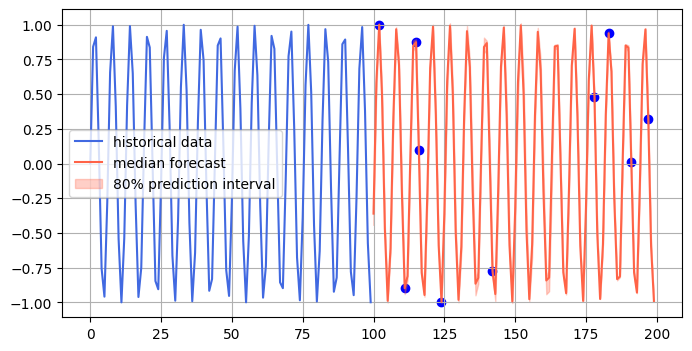

In [80]:
from pyod.models.iforest import IForest

# Initialize the model
model = IForest()

# Fit the model on the training data
model.fit(median_chronos.reshape(-1, 1))

# Predict anomalies on the test data
prediction = model.predict(median_chronos.reshape(-1, 1))



print("Test Data Anomalies:")
print(prediction)


plt.figure(figsize=(8, 4))
plt.plot(train_data["Sin(X)"], color="royalblue", label="historical data")
plt.plot(forecast_index, median_chronos, color="tomato", label="median forecast")
for i, value in enumerate(prediction):
    if value == 1:
        print(f"Anomaly and time step: {len(train_data["Sin(X)"])+i}")
        plt.scatter(len(train_data["Sin(X)"])+i, median_chronos[i], color='blue', label="Predicted Anomaly" if i == 0 else "")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

# Prediction of Anomalies using Chronos

In [81]:
# Use the anomalies_train dataset to put it into chronos and predict the next datapoints of the same length as the dataset



context = torch.tensor(anomalies_train, dtype=torch.bfloat16)
prediction_length = len(anomalies_train)
print(prediction_length)

quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
)


_, median, _ = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
print(median)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


100
tensor([ 4.0403e-09,  4.0403e-09,  9.8173e-01,  4.0403e-09,  4.0403e-09,
        -9.6583e-01,  4.0403e-09,  4.0403e-09,  9.6583e-01,  4.0403e-09,
         4.0403e-09, -9.4357e-01,  4.0403e-09,  4.0403e-09,  9.6583e-01,
         4.0403e-09,  4.0403e-09, -9.4039e-01,  4.0403e-09,  4.0403e-09,
         9.6159e-01,  4.0403e-09,  4.0403e-09, -9.4145e-01,  4.0403e-09,
         4.0403e-09,  9.6371e-01,  4.0403e-09,  4.0403e-09, -9.3508e-01,
         4.0403e-09,  4.0403e-09,  9.3508e-01,  4.0403e-09,  4.0403e-09,
        -9.2872e-01,  4.0403e-09,  4.0403e-09,  9.5735e-01,  4.0403e-09,
         4.0403e-09, -9.2872e-01,  4.0403e-09,  4.0403e-09,  9.4569e-01,
         4.0403e-09,  4.0403e-09, -9.2660e-01,  4.0403e-09,  4.0403e-09,
         9.4357e-01,  4.0403e-09,  4.0403e-09, -9.2236e-01,  4.0403e-09,
         4.0403e-09,  9.2236e-01,  4.0403e-09,  4.0403e-09, -9.1812e-01,
         4.0403e-09,  4.0403e-09,  9.2872e-01,  4.0403e-09, -9.2740e-01,
         4.1482e-09,  4.1482e-09,  9.2196e-01, 

Index: 2, Value: 0.9092974268256817
Index: 5, Value: -0.9589242746631385
Index: 8, Value: 0.9893582466233818
Index: 11, Value: -0.9999902065507035
Index: 14, Value: 0.9906073556948704
Index: 17, Value: -0.9613974918795568
Index: 20, Value: 0.9129452507276277
Index: 24, Value: -0.9055783620066238
Index: 27, Value: 0.956375928404503
Index: 30, Value: -0.9880316240928618
Index: 33, Value: 0.9999118601072672
Index: 36, Value: -0.9917788534431158
Index: 39, Value: 0.9637953862840878
Index: 42, Value: -0.9165215479156338
Index: 46, Value: 0.9017883476488092
Index: 49, Value: -0.9537526527594719
Index: 52, Value: 0.9866275920404853
Index: 55, Value: -0.9997551733586199
Index: 58, Value: 0.9928726480845371
Index: 61, Value: -0.9661177700083929
Index: 64, Value: 0.9200260381967907
Index: 71, Value: 0.9510546532543747
Index: 74, Value: -0.9851462604682474
Index: 77, Value: 0.9995201585807313
Index: 80, Value: -0.9938886539233752
Index: 83, Value: 0.9683644611001854
Index: 86, Value: -0.923458447

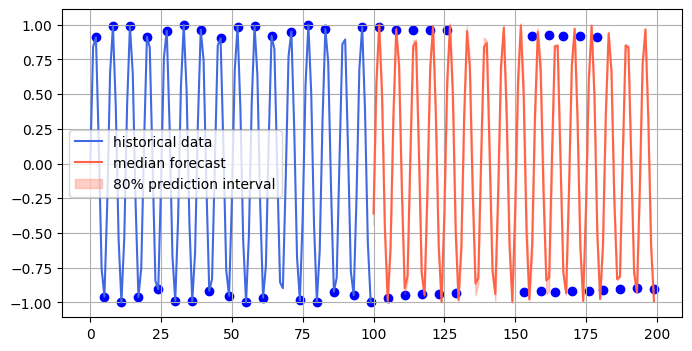

In [92]:
# plot the values
indeces = range(0, len(median))


plt.figure(figsize=(8, 4))
plt.plot(train_data["Sin(X)"], color="royalblue", label="historical data")
plt.plot(forecast_index, median_chronos, color="tomato", label="median forecast")
for i, value in enumerate(anomalies_train):
    if value > 0.1 or value < -0.1:
        print(f"Index: {i}, Value: {value}")
        plt.scatter(i, train_data["Sin(X)"][i], color='blue', label="Predicted Anomaly" if i == 0 else "")

for i, value in enumerate(median):
    if (value > 0.1 or value < -0.1) and (median_chronos[i] > 0.4 or median_chronos[i] < -0.4): 
        print(f"Anomaly and time step: {len(train_data["Sin(X)"])+i}")
        plt.scatter(len(train_data["Sin(X)"])+i, value, color='blue', label="Predicted Anomaly" if i == 0 else "")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

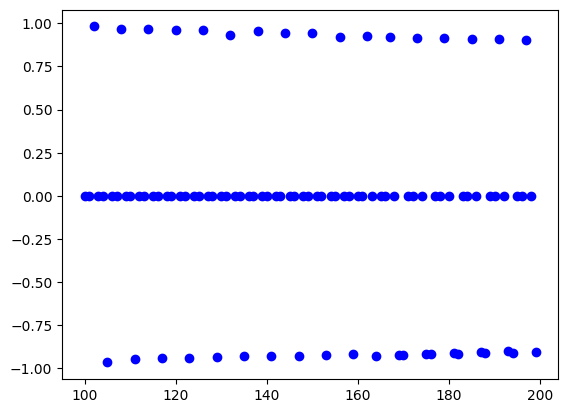

In [87]:
for i, value in enumerate(median):
        plt.scatter(len(train_data["Sin(X)"])+i, median[i], color='blue', label="Predicted Anomaly" if i == 0 else "")


plt.show()